In [ ]:
!pip install torch torchvision matplotlib tqdm


In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
import numpy as np


In [ ]:
class VAE(nn.Module):
    def __init__(self, latent_dim=128):
        super(VAE, self).__init__()

        # Encoder
        self.encoder = nn.Sequential(
            nn.Conv2d(3, 32, kernel_size=4, stride=2, padding=1),  # 64x64 -> 32x32
            nn.ReLU(),
            nn.Conv2d(32, 64, kernel_size=4, stride=2, padding=1), # 32x32 -> 16x16
            nn.ReLU(),
            nn.Conv2d(64, 128, kernel_size=4, stride=2, padding=1), # 16x16 -> 8x8
            nn.ReLU(),
            nn.Flatten()
        )

        # Latent space
        self.fc_mu = nn.Linear(128 * 8 * 8, latent_dim)
        self.fc_logvar = nn.Linear(128 * 8 * 8, latent_dim)

        # Decoder
        self.decoder_input = nn.Linear(latent_dim, 128 * 8 * 8)

        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(128, 64, kernel_size=4, stride=2, padding=1, output_padding=0),  # 8x8 -> 16x16
            nn.ReLU(),
            nn.ConvTranspose2d(64, 32, kernel_size=4, stride=2, padding=1, output_padding=0),  # 16x16 -> 32x32
            nn.ReLU(),
            nn.ConvTranspose2d(32, 3, kernel_size=4, stride=2, padding=1, output_padding=0),  # 32x32 -> 64x64
            nn.Sigmoid()
        )

    def reparameterize(self, mu, logvar):
        """Applies reparameterization trick: z = mu + sigma * epsilon"""
        std = torch.exp(0.5 * logvar)
        eps = torch.randn_like(std)
        return mu + eps * std

    def forward(self, x):
        encoded = self.encoder(x)
        mu = self.fc_mu(encoded)
        logvar = self.fc_logvar(encoded)
        z = self.reparameterize(mu, logvar)
        z = self.decoder_input(z).view(-1, 128, 8, 8)
        decoded = self.decoder(z)
        return decoded, mu, logvar


In [ ]:
transform = transforms.Compose([
    transforms.Resize((64, 64)),
    transforms.ToTensor()
])

dataset = torchvision.datasets.CelebA(root="./data", split="train", download=True, transform=transform)
dataloader = DataLoader(dataset, batch_size=64, shuffle=True)


Files already downloaded and verified


In [ ]:
def loss_function(recon_x, x, mu, logvar):
    """VAE Loss = Reconstruction Loss + KL Divergence Loss"""
    recon_loss = nn.functional.mse_loss(recon_x, x, reduction='sum')
    kl_loss = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())
    return recon_loss + kl_loss

vae = VAE(latent_dim=512)
optimizer = optim.Adam(vae.parameters(), lr=0.001)


In [ ]:
num_epochs = 20
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
vae.to(device)

print("Starting training...")

for epoch in range(num_epochs):
    train_loss = 0
    print(f"\nEpoch {epoch+1}/{num_epochs} ------------------------")

    for batch_idx, batch in enumerate(dataloader):
        images, _ = batch
        images = images.to(device)

        optimizer.zero_grad()

        # Forward pass
        recon_images, mu, logvar = vae(images)
        loss = loss_function(recon_images, images, mu, logvar)

        # Print loss every few batches
        if batch_idx % 100 == 0:
            print(f"Batch {batch_idx}/{len(dataloader)} - Loss: {loss.item():.4f}")

        # Backward pass
        loss.backward()
        optimizer.step()

        train_loss += loss.item()

    # Print average loss per epoch
    avg_loss = train_loss / len(dataloader)
    print(f"Epoch [{epoch+1}/{num_epochs}] - Avg Loss: {avg_loss:.4f}")

print("Training completed!")


Starting training...

Epoch 1/20 ------------------------
Batch 0/2544 - Loss: 68763.0078
Batch 100/2544 - Loss: 27786.0742
Batch 200/2544 - Loss: 22386.1445
Batch 300/2544 - Loss: 23198.4160
Batch 400/2544 - Loss: 21861.1777
Batch 500/2544 - Loss: 19868.8281
Batch 600/2544 - Loss: 20411.2871
Batch 700/2544 - Loss: 19465.9570
Batch 800/2544 - Loss: 19580.1328
Batch 900/2544 - Loss: 19026.8613
Batch 1000/2544 - Loss: 18019.0938
Batch 1100/2544 - Loss: 16519.1816
Batch 1200/2544 - Loss: 17232.6270
Batch 1300/2544 - Loss: 15536.5645
Batch 1400/2544 - Loss: 15366.4570
Batch 1500/2544 - Loss: 16394.3145
Batch 1600/2544 - Loss: 14377.1885
Batch 1700/2544 - Loss: 13930.5479
Batch 1800/2544 - Loss: 15058.3691
Batch 1900/2544 - Loss: 14986.3916
Batch 2000/2544 - Loss: 14076.5176
Batch 2100/2544 - Loss: 14767.0215
Batch 2200/2544 - Loss: 14754.2812
Batch 2300/2544 - Loss: 13433.7295
Batch 2400/2544 - Loss: 13909.1367
Batch 2500/2544 - Loss: 14281.1992
Epoch [1/20] - Avg Loss: 18219.0087

Epoch 2

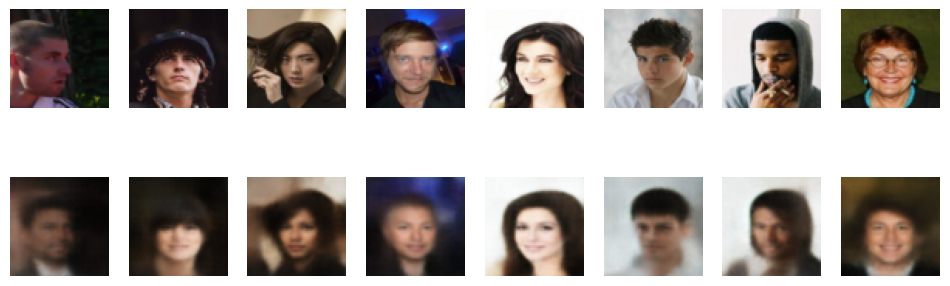

In [ ]:
vae.eval()
with torch.no_grad():
    test_images, _ = next(iter(dataloader))
    test_images = test_images[:8].to(device)

    recon_images, _, _ = vae(test_images)

    fig, axes = plt.subplots(2, 8, figsize=(12, 4))
    for i in range(8):
        axes[0, i].imshow(test_images[i].permute(1, 2, 0).cpu().numpy())
        axes[1, i].imshow(recon_images[i].permute(1, 2, 0).cpu().numpy())

        axes[0, i].axis("off")
        axes[1, i].axis("off")

    plt.show()


In [ ]:
torch.save(vae.state_dict(), "vae_celeba.pth")
